# The Coliseum class

The Coliseum Class contains all the Entry and Exit strategies and provides an interface to interact with all of them in order to:
- Compute the EntryRequest and ExitRequests.
- Plot the strategies.

The things it does not do are:
- It does not create the exit strategies when an entry trade is created.

In order to work with the *Coliseum* objects, we need to first create a *Portfolio* object and one or more *Strategy* objects. The following code will take care of that.

If the request is accepted an actual trade will be performed, or simulated. 
- If it was an entry market request: An exit market strategy will be assigned to the trade.
- If it was an exit market request: Its corresponding exit strategy will be removed.


### Import libraries

In [4]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
%matplotlib qt

import sys
sys.path.insert(0, "..")  # Adds higher directory to python modules path.

from traphing.data_classes import Velas, Portfolio

from traphing.strategies import Trade, Coliseum
from traphing.strategies.entry import EntryStrategy, CrossingMovingAverages, EarlySessionTrendFollower
from traphing.strategies.exit import ExitStrategy, StopLoss

from traphing.utils import Timeframes, unwrap
import traphing.utils  as ul

from traphing.graph.Gl import gl

folder_images = "./images/python_generated/strategies/"

### Set up a portfolio

In [5]:
symbol_names = ["AUDCHF", "AUDCAD"]
timeframes = [Timeframes.M15, Timeframes.D1]
portfolio_name = "my_portfolio"

storage_folder = "../tests/data/storage/"

portfolio = Portfolio(portfolio_name, symbol_names, timeframes)
portfolio.load_data_from_csv(storage_folder)

start_time = dt.datetime(2019,7,20); end_time = dt.datetime(2019,7,25)
portfolio.set_time_interval(start_time,end_time)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows
Size ../tests/data/storage/D1/AUDCHF_D1.csv:  4894  rows
Size ../tests/data/storage/M15/AUDCAD_M15.csv:  99483  rows
Size ../tests/data/storage/D1/AUDCAD_D1.csv:  4963  rows


### Create one or more entry trading strategies

In [6]:
#### First strategy
symbol_name = symbol_names[0]
timeframe = timeframes[0]
portfolio_params = {"symbol_names":[symbol_name], "timeframes":[timeframe]}
slow_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args": {"n":50}}
fast_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args":{"n":30}}
indicators_params = {"fast_MA": fast_MA_params, "slow_MA": slow_MA_params}
exit_strategy_params = {"class_name":"TrailingStop",
                        "params":{"indicators":{"stop_loss_pct":0.1}}}
params = {"portfolio": portfolio_params, "indicators": indicators_params, "exit_strategy":exit_strategy_params}
entry_strategy1 = CrossingMovingAverages("Crossing averages", portfolio)
entry_strategy1.set_params(params)

#### Second strategy
symbol_name = symbol_names[1]
timeframe = timeframes[0]
portfolio_params = {"symbol_names":[symbol_name], "timeframes":[timeframe]}
indicators_params = {"time":dt.time(2)}
exit_strategy_params = {"class_name":"ExitTime",
                        "params":{"indicators":{"time":dt.time(15)}}}
params = {"portfolio": portfolio_params, "indicators": indicators_params, "exit_strategy":exit_strategy_params}
entry_strategy2 = EarlySessionTrendFollower("ESTF", portfolio)
entry_strategy2.set_params(params)

## Coliseum instance

There is no initialization parameters for the Coliseum class. When an instance is created, the internal data structures are initilized with no data. 

In [7]:
coliseum = Coliseum()

### Adding and deleting strategies

Once the object is created, we add strategies by simply feeding the strategy objects.

In [8]:
coliseum.add_entry_strategy(entry_strategy1)
coliseum.add_entry_strategy(entry_strategy2)

In [9]:
coliseum.entry_strategies_names_list

['Crossing averages', 'ESTF']

In [11]:
coliseum.del_entry_strategy("ESTF")
coliseum.entry_strategies_names_list

['Crossing averages']

In [12]:
coliseum.add_entry_strategy(entry_strategy1)

In [13]:
coliseum.exit_strategies_names_list

[]

## Handling the Priority Queue

In [14]:
queue = coliseum.compute_requests_queue()

In [15]:
unwrap(coliseum)

<Coliseum>	object has children:
    <dict>	_entry_strategies_dict
    <dict>	_exit_strategies_dict
    <PriorityQueue>	queue

  <PriorityQueue>	queue has children:
      <int>	maxsize:	0
      <list>	queue
      <lock>	mutex
      <Condition>	not_empty
      <Condition>	not_full
      <Condition>	all_tasks_done
      <int>	unfinished_tasks:	5

    <Condition>	all_tasks_done has children:
        <lock>	_lock
        <lock>	_lock
        <lock>	_lock
        <deque>	_waiters

      <deque>	_waiters has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

    <Condition>	not_full has children:
        <lock>	_lock
        <lock>	_lock
        <lock>	_lock
        <deque>	_waiters

      <deque>	_waiters has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

    <Condition>	not_empty has children:
        <lock>	_lock
        <lock>	_lock
        <lock>	_lock
        <

## We can then process the requests

In [16]:
while (coliseum.queue.empty() == False):
    print(coliseum.queue.get())

(Timestamp('2019-07-23 05:00:00'), <traphing.strategies.entry._core_classes.EntryTradeRequest object at 0x7f64449f9e90>)
(Timestamp('2019-07-23 17:00:00'), <traphing.strategies.entry._core_classes.EntryTradeRequest object at 0x7f6446f0ce90>)
(Timestamp('2019-07-24 03:00:00'), <traphing.strategies.entry._core_classes.EntryTradeRequest object at 0x7f63f1451e90>)
(Timestamp('2019-07-24 04:45:00'), <traphing.strategies.entry._core_classes.EntryTradeRequest object at 0x7f63f1448f90>)
(Timestamp('2019-07-25 15:30:00'), <traphing.strategies.entry._core_classes.EntryTradeRequest object at 0x7f6448b34990>)


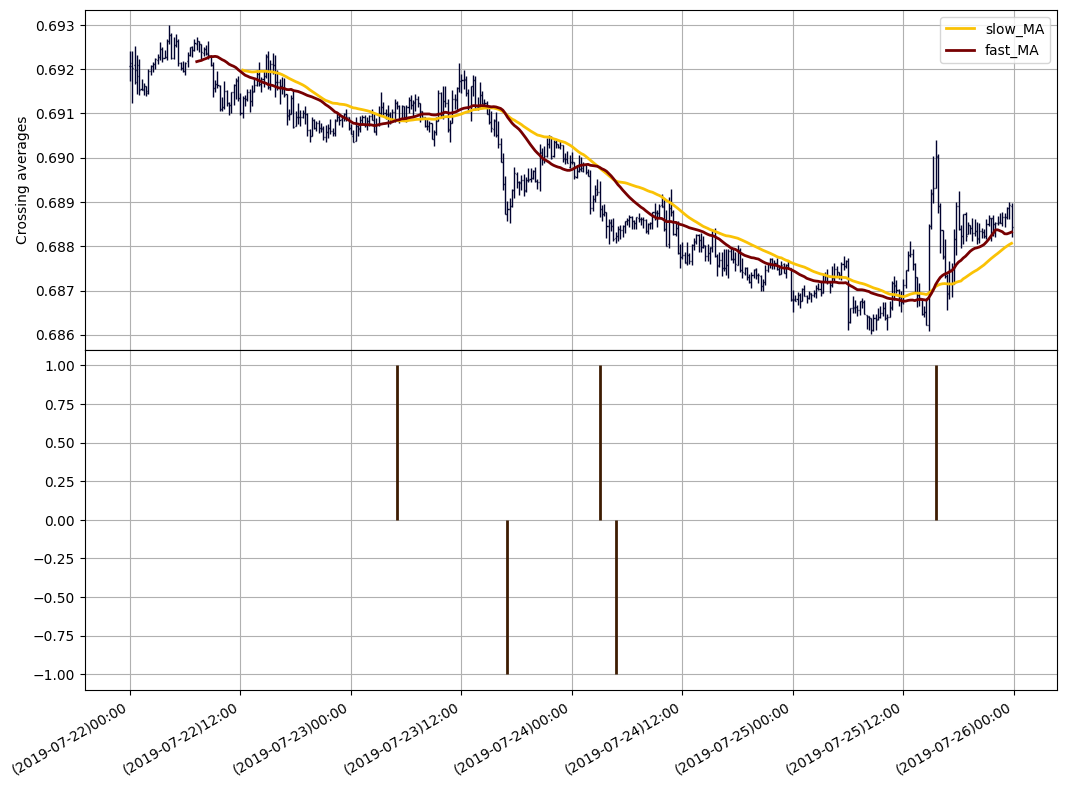

In [18]:
image_name = "entry_and_exit.png"; img_path = folder_images + image_name
gl.init_figure()

n_strategies = len(coliseum.entry_strategies_names_list)

n_rows, n_cols = n_strategies*2,1; size_inches = [12, 8]
ax = None; axes_list = []
for i in range(n_strategies*2):
    ax = gl.subplot2grid((n_rows, n_cols),(i,0), sharex = ax)
    axes_list.append(ax)
    
i = 0
for strategy_id in coliseum.entry_strategies_names_list:
    ax1 = axes_list[i*2]; ax2 = axes_list[i*2+1]
    entry_strategy = coliseum.get_entry_strategy(strategy_id)
    entry_strategy_series = entry_strategy.compute_input_series()
    entry_series = entry_strategy.compute_trigger_series()

    symbol_name = entry_strategy.symbol_names[0]
    timeframe = entry_strategy.timeframes[0]
    portfolio[symbol_name][timeframe].plot_barchart(axes = ax1, labels = ["", "", strategy_id])
    gl.plot(entry_strategy_series.index, entry_strategy_series, legend = list(entry_strategy_series.columns), axes =ax1)

    gl.stem(entry_strategy_series.index,entry_series, axes = ax2, legend = "Trades")

    i = i+1
gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)

gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)